# `tundraden` examples

## Generating correlated regressors and target

Let's first generate some random correlated regressors. `generate_correlated_data` generates random data using a multivariate normal distribution. So by setting the covariance matrix one can decide how correlated the regressors are. Below I generate 3 regressors; the first 2 are strongly correlated to each other and the third one is uncorrelated to the 2 others. The regressors are then pair-plotted using the `pairplot` function:

In [18]:
import tundraden
import numpy as np
import matplotlib.pyplot as plt

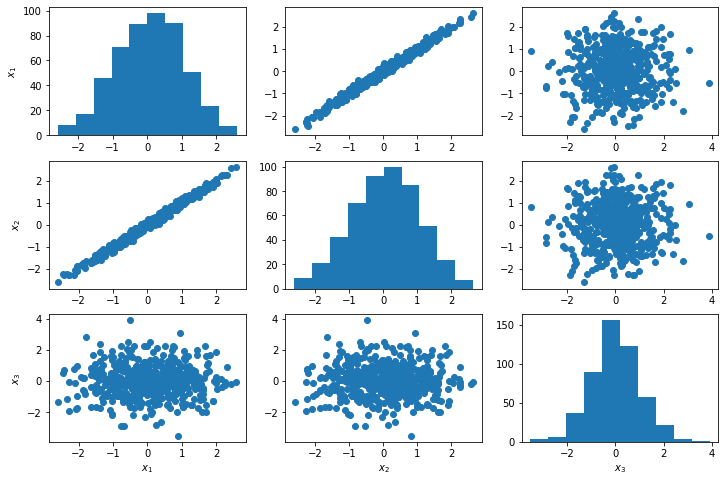

In [19]:
n_samples = 500
covariance_matrix = np.array([
    [1.00, 1.00, 0.00],
    [1.00, 1.01, 0.00],
    [0.00, 0.00, 1.00],
])
X = tundraden.generate_correlated_data(covariance_matrix, n_samples)

plt.figure(figsize=(12,8))
tundraden.pairplot(X, var_names=['$x_1$', '$x_2$', '$x_3$'])
plt.show()

We can clearly see the first 2 regressors are strongly correlated. The plots on the diagonal simply show the individual regressors distribution.

Below I generate the target variable using arbitrary weights for each regressor. I also add some extra noise:

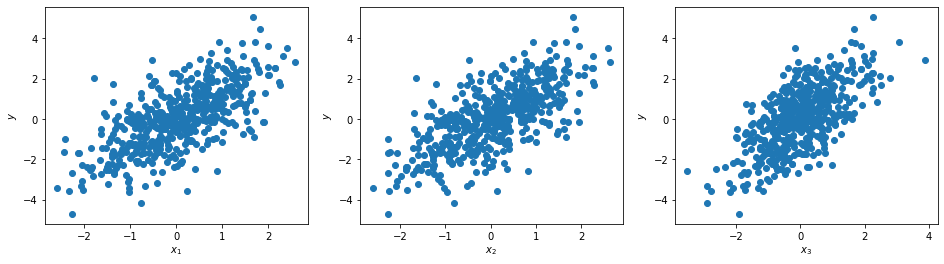

In [20]:
weights = np.array([-1, 2, 1])
sigma = 0.5
Y = tundraden.generate_target(X, weights, sigma)

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,i], Y)
    plt.xlabel('$x_%i$'%(i+1))
    plt.ylabel('$y$')
plt.show()

## OLS linear regression

The simplest model is an OLS linear regression and can be performed with the `LinearRegression` class:

In [4]:
model = tundraden.LinearRegression()
model.fit(X, Y)
model.coef

array([-0.80781942,  1.82494549,  1.02075403])

Depending on the run the estimated weights above can be quite poor.

A way of measuring the multicollinearity of the data is to calculate the coefficient of multiple determination and/or the variance inflation factor of each of the predictors:

In [5]:
tundraden.partial_r2(X)

array([9.89932958e-01, 9.90640138e-01, 9.74754301e-04])

In [6]:
tundraden.partial_vif(X)

array([ 99.33404679, 106.83918462,   1.00097571])

It can be seen both the partial coefficients of determination and the variance inflation ratios are high for the first two regressors.

## Ridge regression and hyper-parameter tuning

### Simple train-test split

To deal with multicollinearity, one can consider a Ridge regression model. The RidgeRegression class can do Ridge regression. To chose the optimal hyper-parameter $\lambda$, below I first do a naive hold-out split. The optimal $\lambda$ value is the one giving the lowest error on the test split.

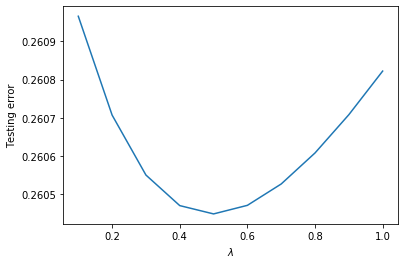

In [7]:
lambdas = np.linspace(0.1, 1.0, 10)

X_train, X_test, Y_train, Y_test = tundraden.train_test_split(X, Y, train_size=0.67)
testing_errors = np.zeros(len(lambdas))
for i, lambda_ in enumerate(lambdas):
    model = tundraden.RidgeRegression(lambda_)
    model.fit(X_train, Y_train)
    testing_errors[i] = model.test(X_test, Y_test)

plt.figure()
plt.plot(lambdas, testing_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Testing error')
plt.show()

Since the split into training and testing sets is done randomly, the code snippet above can give different results if run multiple times.

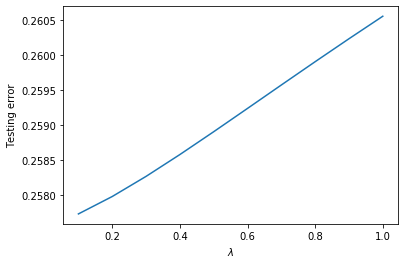

In [8]:
X_train, X_test, Y_train, Y_test = tundraden.train_test_split(X, Y, train_size=0.67)
testing_errors = np.zeros(len(lambdas))
for i, lambda_ in enumerate(lambdas):
    model = tundraden.RidgeRegression(lambda_)
    model.fit(X_train, Y_train)
    testing_errors[i] = model.test(X_test, Y_test)

plt.figure()
plt.plot(lambdas, testing_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Testing error')
plt.show()

### K-Fold cross-validation

To deal with this on can do K-fold cross-validation. The `RidgeCV` manages the hyper-parameter tuning using cross-validation. Below I use 10 folds.

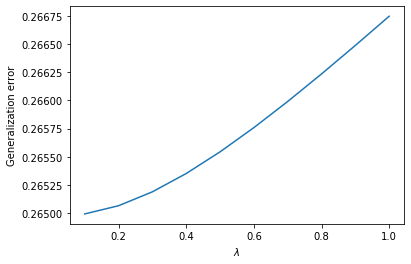

In [23]:
modelCV = tundraden.RidgeCV(cv=10)
modelCV.fit(X, Y)

plt.figure()
plt.plot(modelCV.lambda_grid, modelCV.generalization_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Generalization error')
plt.show()

The optimal $\lambda$ is:

In [24]:
modelCV.lambda_

0.1

### Leave-one-out cross-validation

I can also do leave-one-out cross-validation, which is the default behavior of the `RidgeCV` class.

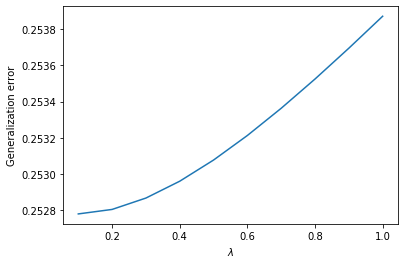

In [11]:
modelCV = tundraden.RidgeCV()
modelCV.fit(X, Y)

plt.figure()
plt.plot(modelCV.lambda_grid, modelCV.generalization_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Generalization error')
plt.show()

And the optimal $\lambda$ is:

In [12]:
modelCV.lambda_

0.1

### Two-level cross-validation

The generalization error of a fitted `RidgeCV` object is a biased estimate of the performance of the model. To get an unbiased estimate of the generalization error, two-level cross-validation is prefered. The `NestedRidgeCV` class can perform two-level cross-validation.

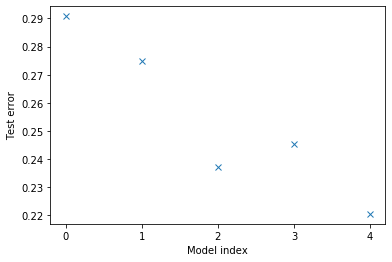

In [13]:
nestedCV = tundraden.NestedRidgeCV(outer_cv=5, inner_cv=10)
nestedCV.run(X, Y)

plt.figure()
plt.plot(nestedCV.test_errors, 'x')
plt.xlabel('Model index')
plt.ylabel('Test error')
plt.xticks(np.arange(len(nestedCV.test_errors)))
plt.show()

The `run` method of a `NestedRidgeCV` object trains as many `RidgeCV` models as outer-folds. In this case we have 5 models. The `models` attribute contains all the trained models. The optimal hyper-parameter and the weights of each model can easily be retreived:

In [14]:
nestedCV.models[3].coef

array([-0.51116866,  1.53812301,  1.0008532 ])

In [15]:
nestedCV.models[3].lambda_

0.1

The overall generalization error is:

In [16]:
nestedCV.generalization_error

0.25369663599069864

The hyper-parameters of all the models can be directly retreived with the `lambdas` method:

In [17]:
nestedCV.lambdas

[0.1, 0.1, 0.1, 0.1, 0.1]

Here all the models have the same $\lambda$, but it's not usually the case!